### Group Members:

- Name, matriculation number
- Name, matriculation number
- Name, matriculation number

# Assignment 2: Binary and Categorical Classification

For this assignment, we will use a similar two-layer network as Assignment 1 to implement binary and categorical classification using only `NumPy` package, without relying on `PyTorch` or any deep learning libraries.

We will implement Binary Cross Entropy Loss and Categorical Cross Entropy Loss and their gradient manually with efficient matrix computation, and evaluate accuracy for two classification tasks.  


## Theoretical Questions

We will build and train a two-layer network similar to Assignment 1.
Besides, we will apply **Logistic Function** ($\sigma$) on the logits for binary classification and **Stable Softmax Function** ($\tilde{\mathcal S}$) on the logits for categorical classification.

Questions in this section concern:

1. Comparison between normal softmax $\mathcal S$ and stable softmax $\tilde{\mathcal S}$
2. Compute derivative of $\tilde{\mathcal S}$ that should be applied in the coding section
3. Weight/Parameter Initialization
4. Discussion on Evaluation Metrics of classification tasks

### Task 1.1 Proof of Stable Softmax

The softmax function is defined as:

$$
\mathcal S(z_o) = \frac{e^{z_o}}{\sum\limits_{o'} e^{z_{o'}}}
$$

However, when $ z_o $ has large values, the exponential $ e^{z_o} $ may grow too large, leading to numerical instability (e.g., overflow issues).
To improve stability, we introduce the **stable softmax**:

$$
\tilde{\mathcal S}(z_o) = \frac{e^{z_o - z_{\max}}}{\sum\limits_{o'} e^{z_{o'} - z_{\max}}}
$$

where $z_{\max} = \max\limits_o z_o$.

Prove that stable softmax is mathematically equivalent to the original softmax function.

Discuss how stable softmax improves numerical stability, for instance, what will happen when $z_o$ is too large, or too small?

Answer: ...

### Task 1.2 Derivative of Stable Softmax


Recall that in the lecture slides, when we compute gradient with respect to $w^{(1)}$ and $w^{(2)}$, as part of the chain rule, we replace $\frac{\partial\mathcal J^{[n]}}{\partial\mathcal y_o^{[n]}}\frac{\partial\mathcal y_o^{[n]}}{\partial\mathcal z_o^{[n]}}$ by $\frac{\partial\mathcal J^{[n]}}{\partial\mathcal z_o^{[n]}}$ when we choose a good activation function.

When normal softmax is applied, we have $\frac{\partial\mathcal J^{[n]}}{\partial\mathcal z_o^{[n]}} = y_o^{[n]} - t_o^{[n]}$. Prove that $\frac{\partial\mathcal J^{[n]}}{\partial\mathcal z_o^{[n]}}$ will return the same format when the activation function is stable softmax.



Answer: ...

### Task 1.3 Weight Initialization

Why do we need to randomly initialize the weights before training starts?

1. Proof that a network with constantly initialized weights perform like a network with one hidden unit.
2. Show that gradient decent is not able to change this behavior and will keep all neurons in the hidden layer identical throughout training.

Answer: ...

### Task 1.4 Evaluation Metrics

If a binary classifier achieves an accuracy greater than 90%, see example plot in the OLAT, does this always indicate good performance? Might high accuracy in this binary classification be misleading? 

What alternative evaluation approaches could better capture model performance in such scenarios?



Answer: ...

## Coding

**<font color='red' size='5'>This section has to be submitted by 11:59 p.m. on Wednesday, March 26, to be graded.</font>**

### Dataset

We will use two different datasets, the *churn* dataset https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset for a binary classification and the *winequality-red* dataset https://archive.ics.uci.edu/dataset/186/wine+quality for a categorical classification. Both datasets are available on the UCI Machine Learning repository.

The binary classification dataset contains features extracted from customers of a telecommunication company, which are classified as either churn or not.
The categorical classification dataset contains chemical measurements for seven distinct qualities of a Portuguese white wine.
In the former dataset, the class is indicated in the final column named "Churn", whereas for the latter, target information is provided in the last column named "quality."

Please run the code block below to download the data files.

In [42]:
import os
import zipfile
import urllib.request

# Download the two dataset files
dataset_files = {
    "churn_data.zip": "https://archive.ics.uci.edu/static/public/563/iranian+churn+dataset.zip",
    "winequality-red.csv": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
}

for name, url in dataset_files.items():
    base, extension = os.path.splitext(name)  # Get file name without extension

    if os.path.exists(name):
        print(f"File '{name}' already exists. Skipping download.")
    else:
        # Download the file
        urllib.request.urlretrieve(url, name)
        print(f"Downloaded {name} successfully.")

    # Check if it's a zip file and if it has been extracted
    if extension == ".zip":
        extracted_file = os.path.join(base + ".csv")  # Expected extracted file name

        if not os.path.exists(extracted_file):
            with zipfile.ZipFile(name, 'r') as zip_ref:
                zip_ref.extractall()
            print(f"Extracted {name} successfully.")

            # Rename the extracted file
            os.rename("Customer Churn.csv", extracted_file)
        else:
            print(f"File '{extracted_file}' already extracted. Skipping extraction.")


File 'churn_data.zip' already exists. Skipping download.
File 'churn_data.csv' already extracted. Skipping extraction.
File 'winequality-red.csv' already exists. Skipping download.


#### Task 2.1: Dataset Loading

The first task deals with the loading of the datasets.
When training networks in `NumPy`, all data needs to be stored as NumPy arrays.
The data should be split between input matrix $\mathbf X \in \mathbb R^{D\times N}$ and target matrix $\mathbf T \in \mathbb R^{O\times N}$.
We need to **add a bias neuron to the input** so that we have $\mathbf X \in \mathbb R^{(D+1)\times N}$


<!-- For the targets, we have to be more careful as there are differences w.r.t. the applied loss function.

*   For binary classification, we need $\mathbf T \in \mathbb R^{1\times N}$.
*   For categorical classification, we only need the class indexes $\vec t = [t^{[1]}, \ldots, t^{[N]}]$ to be in dimension $\mathbb N^N$. -->


Implement a function that returns both the input and the target data for a given dataset.

Note:

1. You can use `csv.reader()` to read the dataset, or rely on other methods such as `pandas`
2. Please note that in the wine dataset CSV file, all values are separated by `;`, whereas in the churn dataset, they are separated by `,`
3. For the wine dataset, convert 6 target values into a one-hot matrix so that the dimension is $\mathbb R^{6\times N}$. **Be aware that the target values in the wine dataset do not start at index 0.**

In [79]:
import numpy
import csv

def dataset(dataset_file="winequality-red.csv",delimiter=";"):
  # read dataset
  data = []
  with open(dataset_file, 'r') as f:
    reader = csv.reader(f, delimiter = ";"
                       if "winequality" in dataset_file
                       else ",")
    next(reader)
    for row in reader:
        data.append(row)

  print (f"Loaded dataset with {len(data)} samples")

  # Convert to NumPy array
  data = numpy.array(data)

  # Get the input (data samples)
  X = data[:,:-1].astype(numpy.float32)
  # Insert bias neuron (add a column of ones) to the input
  bias = numpy.ones((X.shape[0],1))
  X = numpy.hstack((bias, X))
 

  if dataset_file == "winequality-red.csv":
    # target is in the last column and needs to be converted into one-hot format
    T = data[:, -1].astype(numpy.int32)
    T_adjusted = T - 3
    num_classes = 6
    T_one_hot = numpy.eye(num_classes)[T_adjusted]
    T = T_one_hot.T
  else:
    # target is in the last column and needs to be of type float
    T = data[:, -1].astype(numpy.float32)
    T = T.reshape(1, -1)

  return X.T, T

#### Test 1: Assert Valid Outputs


1. For the churn data, we assure that all dimensions are correct and that class labels are in $\{0, 1\}$.

2. For the wine dataset, we make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb N^{O\times N}$. We verify that each sample in $\mathbf T$ has exactly one active class (one-hot encoding).

In [81]:
# Load datasets using the dataset function
X, T = dataset("churn_data.csv", ",")

# Assert checks for the churn dataset
assert X.shape[0] == 14, X.shape[0]
assert T.shape[0] == 1, T.shape[0]
assert numpy.all(T >= 0) and numpy.all(T <= 1)
assert T.dtype == numpy.float64

# Load wine dataset
X, T = dataset("winequality-red.csv", ";")

# Assert checks for the winequality-red dataset
assert X.shape[0] == 12, X.shape[0]
assert T.shape[0] == 6, T.shape[0]
# assert numpy.all(T >= 0) and numpy.all(T <= 1)
assert numpy.all(numpy.sum(T, axis=0) == 1), "Error: Some samples are not correctly one-hot encoded!" # ensures that each column sums to exactly 1
assert T.dtype == numpy.float64

Loaded dataset with 3150 samples


AssertionError: 

#### Task 2.2: Split Training and Validation Data


The data should be split into 80% for training and 20% for validation. Implement a function that takes the full dataset $(X,T)$ and returns $(X_t, T_t, X_v, T_v)$ accordingly.

Write a function that splits off training and validation samples from a given dataset. **What do we need to assure before splitting?**


In [91]:
def split_training_data(X,T,train_percentage=0.8):
  N = X.shape[1]
  train_size = int(train_percentage * N)
  # split into 80/20 training/validation
  X_train = X[:, :train_size]
  T_train = T[:, :train_size]
  X_val = X[:, train_size:]
  T_val = T[:, train_size:]

  return X_train, T_train, X_val, T_val

#### Task 2.3: Input Data Normalization


Since the data is in different input regimes, we want to normalize the data.

Implement a function that normalizes all input data using the whitening method with given mean and standard deviation.
$$X_{norm} = \frac{X-\mu}{\sigma}$$
Compute the mean ($\mu$) and the standard deviation ($\sigma$) for your dataset.
Make sure that you handle the bias neuron $x_0$ correctly.
Finally, normalize your input data using the implemented function.

Note: Use `numpy.mean()` and `numpy.std()` with the correct dimensions.

In [158]:
def normalize(X_train, X_val):
  # Compute statistics
  mean = numpy.mean(X_train[1:], axis=1, keepdims=True)
  std = numpy.std(X_train[1:], axis=1, keepdims=True)

  # Ensure that the bias neuron is not normalized
  X_train_normalize = X_train.copy()
  X_val_normalize = X_val.copy()

  # Standardize both X_train and X_val
  X_train_normalize[1:] = (X_train[1:] - mean) / std
  X_val_normalize[1:] = (X_val[1:] - mean) / std

  return X_train_normalize, X_val_normalize

### Gradient Descent

To train a two-layer multi-output regression network, we need to implement some functions.
The network output is computed in three steps:

  * Compute network activation for a batch of inputs $\mathbf X$: $\mathbf A = \mathbf W^{(1)}\mathbf X$
  * Call the activation function element-wise: $\mathbf H = g(\mathbf A)$. Here, we rely on the $\tanh$ function. Assure that the hidden neuron bias $\mathbf H_{0,:}$ is set appropriately.
  * Compute the logits $\mathbf Z$ of the batch: $\mathbf Z = \mathbf W^{(2)}\mathbf H$.

#### Task 2.4: Activation of Output

In this task, we will implement the activation functions used in binary and categorical classification:  

1. Logistic Function (for Binary Classification)  
   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$

2. Stable Softmax Function (for Categorical Classification)
  $$
   \tilde{\mathcal S}(z_o) = \frac{e^{z_o - z_{max}}}{\sum\limits_{o'} e^{z_{o'} - z_{max}}}
   $$

In [105]:
def logistic_function(z):
    return 1 / (1 + numpy.exp(-z))

def stable_softmax(z):
    return numpy.exp(z - numpy.max(z, axis=0, keepdims=True)) / numpy.sum(numpy.exp(z - numpy.max(z, axis=0, keepdims=True)), axis=0, keepdims=True)

#### Task 2.5: Network Implementation

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using `numpy` operations. Use $\tanh$ as activation function between two layers.

The function should return both the output $\mathbf Y$ and the output of the hidden units $\mathbf H$ since we will need these in gradient descent. 
When applying binary cross entropy loss, we apply the logistic function $\sigma$ to the logits $\mathbf Z$ before returning it.
When applying categorical cross entropy loss, we apply stable softmax $\tilde{\mathcal S}$ to the logits $\mathbf Z$ before returning it.

In [113]:
def Network(X, Theta, loss_type='bce'):
  W1, W2 = Theta

  # compute activation
  A = numpy.dot(W1, X)

  # compute hidden unit output
  H = numpy.tanh(A)

  # compute network output
  if loss_type == 'bce':
        Y = logistic_function(numpy.dot(W2, H))  # Sigmoid
  else:
        Y = stable_softmax(numpy.dot(W2, H))  # Softmax

  return Y, H

#### Task 2.6: Loss Implementation

Implement a loss function that returns the Binary Cross-Entropy (BCE) loss for binary classification and the Categorical Cross-Entropy (CCE) loss for categorical classification.
Note that for BCE, $O=1$ so that both $\mathbf Y\in\mathbb R^{O\times N}$ and $\mathbf T\in\mathbb N^{O\times N}$ are considered as vectors.

$$
\mathcal J^{\mathrm{BCE}} = -\frac{1}{N} \left[ \mathbf T \log \mathbf Y + (1 - \mathbf T) \log (1 - \mathbf Y) \right] \vec{\mathbf 1}_N
$$

$$
\mathcal J^{\mathrm{CCE}} = -\frac{1}{N} \vec{\mathbf 1}_O^T [\mathbf T \log \mathbf Y] \vec{\mathbf 1}_N
$$

For both losses, the mathematical expressions below can be implemented much easier, by using basic `numpy` or `scipy` functionality.

In [115]:
def loss(Y, T, loss_type):
    if loss_type == 'bce':#BCE
        return -numpy.mean(T * numpy.log(Y) + (1 - T) * numpy.log(1 - Y))
    else:#CCE
        return -numpy.mean(numpy.sum(T * numpy.log(Y), axis=0))

#### Task 2.7: Gradient Implementation

Implement a function that computes and returns the gradient for a given batch $(\mathbf X, \mathbf T)$, the given network outputs $\mathbf Y$ and $\mathbf H$ as well as current parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Make sure to compute the gradient with respect to both weight matrices. Remember that we have used $\sigma$ as the activation function.
Implement the function using the fast version provided in the lecture and make use of `numpy` operations.

In [117]:
def gradient(X, T, Y, H, Theta):
  W1, W2 = Theta

  # Derivative with respect to W2
  g2 = (Y - T) @ H.T

  # Compute the derivative with respect to W1
  g1 = ((W2.T @ (Y - T)) * (1 - H**2)) @ X.T

  return g1, g2


#### Task 2.8: Accuracy Computation


Implement a function that computes the accuracy of the provided network output and the given target values.
Make sure that the implementation supports both binary as well as categorical targets.

In [125]:
def accuracy(Y, T):
  # check if we have binary or categorical classification
  if T.shape[0] == 1:
    # binary classification
    return numpy.mean((Y >= 0.5) == T)
  else:
    # categorical classification
    return numpy.mean(numpy.argmax(Y, axis=0) == numpy.argmax(T, axis=0))

#### Test 2: Test Accuracy Function


Design test data and according logit values with which you can test the correctness of your accuracy function.
Make sure that the accuracy will compute the correct values.
Test both binary and categorical accuracy.

In [127]:
# first, test binary classification
YY = numpy.ones((1,20)) * -5.
YY[0][15:20] = 5
assert(abs(accuracy(YY,numpy.zeros((1,20))) - 0.75) < 1e-8)
assert(abs(accuracy(YY,numpy.ones((1,20))) - 0.25) < 1e-8)

# now, test categorical classification with 4 classes
YY = numpy.ones((4, 20)) * -5  # Shape (C, N) to match function expectations
YY[0, 0:1] = 5
YY[1, 1:4] = 5
YY[2, 4:10] = 5
YY[3, 10:20] = 5
# Modify YY and T to be one-hot encoded
T0 = numpy.eye(4)[numpy.zeros(20, dtype=int)].T
T1 = numpy.eye(4)[numpy.ones(20, dtype=int)].T
T2 = numpy.eye(4)[numpy.ones(20, dtype=int) * 2].T
T3 = numpy.eye(4)[numpy.ones(20, dtype=int) * 3].T
T4 = numpy.eye(4)[numpy.array([0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])].T

# Assertions with modified inputs
assert abs(accuracy(YY, T0) - 0.05) < 1e-8
assert abs(accuracy(YY, T1) - 0.15) < 1e-8
assert abs(accuracy(YY, T2) - 0.3) < 1e-8
assert abs(accuracy(YY, T3) - 0.5) < 1e-8
assert abs(accuracy(YY, T4) - 1.0) < 1e-8

#### Task 2.9: Training Loop


Implement gradient descent for a given number of 10'000 epochs using given input data, initial parameters $\Theta$, loss_type, number of epochs, as well as a learning rate of $\eta=0.1$.

Make use of the normalized dataset from Task 2.3, the network from Task 2.5, the loss from Task 2.6, the gradient from Task 2.7, and the accuracy function from Task 2.8.

Make sure that you train on the training data only, and not on the validation data.
In each loop, compute and store the training loss, training accuracy, validation loss and validation accuracy.
At the end, return the lists of these values.


In [139]:
def train(X_train, T_train, X_val, T_val, Theta, loss_type, num_epochs=10000, learning_rate=0.1):

  W1, W2 = Theta

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(num_epochs):
    # train on training set
    # ... compute network output on training data
    Y_train, H_train = Network(X_train, (W1, W2), loss_type)
    # ... compute loss from network output and target data
    loss_train = loss(Y_train, T_train, loss_type)
    # ... compute gradient and perform weight update
    g1, g2 = gradient(X_train, T_train, Y_train, H_train, (W1, W2))
    W1 -= learning_rate * g1
    W2 -= learning_rate * g2
    # accuracy
    acc_train = accuracy(Y_train, T_train)
    # ... remember loss
    train_loss.append(loss_train)
    # ... compute training set accuracy
    train_acc.append(acc_train)

    # test on validation data

    # ... compute network output on validation data
    Y_val, _ = Network(X_val, (W1, W2), loss_type)
    # ... compute loss from network output and target data
    loss_val = loss(Y_val, T_val, loss_type)
    #accuracy
    acc_val = accuracy(Y_val, T_val)
    # ... remember loss
    val_loss.append(loss_val)
    # ... compute validation set accuracy
    val_acc.append(acc_val)

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

#### Task 2.10: Plotting Function


Implement a function that takes four lists containing the training loss, the training accuracy, the validation loss and the validation accuracy.
Plot the two losses into one plot, and the two accuracies into another plot.

In [141]:
from matplotlib import pyplot
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.set_xlabel("Epoch")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.set_xlabel("Epoch")
  ax.legend()

#### Task 2.11: Binary Classification


1. Load the data for binary classification, using the ``"churn_data.csv"`` file.
2. Split the data into training and validation sets.
3. Normalize both training and validation input data using the function from Task 2.3.
4. Instantiate the weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using the Xavier method as introduced in the lecture
5. Train the network on the churn data with the learning rate of **$\eta=0.1$** for 10'000 epochs and plot the training and validation accuracies and losses.



Loaded dataset with 3150 samples


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


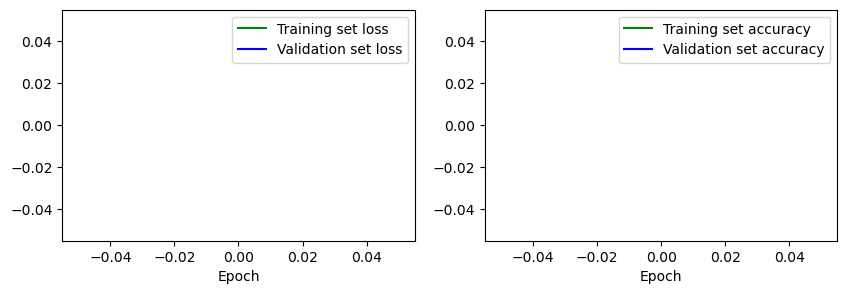

In [145]:

# load dataset
X, T = dataset("churn_data.csv", ",")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T)
# normalize input data
X_train, X_val = normalize(X_train, X_val)

K = X_train.shape[0]
D = 8
O = 1
W1 = numpy.random.randn(D, K) * numpy.sqrt(1 / K)
W2 = numpy.random.randn(0, D) * numpy.sqrt(1 / K)
Theta = [W1, W2]

# train network on our data
results = train(X_train, T_train, X_val, T_val, Theta, loss_type="bce", num_epochs=10000, learning_rate=0.1)

# plot the results
plot(*results)

#### Task 2.12: Categorical Classification


1. Load the data for categorical classification, using the ``"winequality-red.csv"`` file.
2. Split the data into training and validation sets.
3. Normalize both training and validation input data using the function from Task 2.3.
4. **How many input and output neurons do we need?** Change the number of input, hidden, and output neurons accordingly. Select an appropriate number of hidden neurons $K$.
5. Instantiate the weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using the Xavier method as introduced in the lecture
6. Train the network on the winequality-red dataset with the learning rate of **$\eta=0.1$** for 10'000 epochs and plot the training and validation accuracies and losses.



In [ ]:

# load dataset
X, T = ...
# split dataset
X_train, T_train, X_val, T_val = ...
# normalize input data
X_train, X_val = ...

K = ...
D = ...
O = ...
W1 = ...
W2 = ...
Theta = [W1, W2]

# train network on our data
results = ...

# plot the results
plot(...)